In [ ]:
# !pip install tensorflow
# !pip install imbalanced-learn

In [104]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [122]:
# Import the CSV files
df_train = pd.read_csv('extracted_data\df_train.csv')
df_test = pd.read_csv('extracted_data\df_test.csv')

In [123]:
# Separate features and target variable from df_train
X = df_train.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_train['TARGET']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data
X_val_scaled = scaler.transform(X_val)

# Ensure df_test has the same columns as X_train
df_test_aligned = df_test[X_train.columns]

# Transform the test data
X_test_scaled = scaler.transform(df_test_aligned)

In [124]:
# Define the SMOTE sampler
smote = SMOTE(sampling_strategy=0.5, k_neighbors=10,
              random_state=42, n_jobs=-1)
# Fit the sampler to balance the training data
X_train_balanced, y_train_balanced = smote.fit_resample(
    X_train_scaled, y_train)

e:\WEB Projects\Home Credit Default Risk\.venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [125]:
model = Sequential()
model.add(Dense(512, input_dim=X_train_balanced.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

e:\WEB Projects\Home Credit Default Risk\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [126]:
# Compile the model with class weights
# class_weights = {0: 1., 1: 10.}  # Adjust the weights as needed


# Compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Define early stopping

early_stopping = EarlyStopping(
monitor='val_loss', patience=5, restore_best_weights=True)

In [127]:
history = model.fit(X_train_balanced, y_train_balanced, validation_data=(
    X_val_scaled, y_val), epochs=100, batch_size=256, callbacks=[early_stopping])

Epoch 1/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6134 - loss: 0.6821 - val_accuracy: 0.8008 - val_loss: 0.5589
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6774 - loss: 0.6007 - val_accuracy: 0.7422 - val_loss: 0.4991
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6921 - loss: 0.5811 - val_accuracy: 0.7337 - val_loss: 0.4977
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7005 - loss: 0.5699 - val_accuracy: 0.7164 - val_loss: 0.4933
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7096 - loss: 0.5595 - val_accuracy: 0.7527 - val_loss: 0.4764
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7190 - loss: 0.5531 - val_accuracy: 0.7443 - val_loss: 0.4713
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7216 - loss: 0.5517 - val_accuracy: 0.7725 - val_loss: 0.4440
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7209 - loss: 0.5487 - 

In [128]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Validation Accuracy: {val_accuracy}')


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8204 - loss: 0.4046
Validation Accuracy: 0.8231610059738159


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


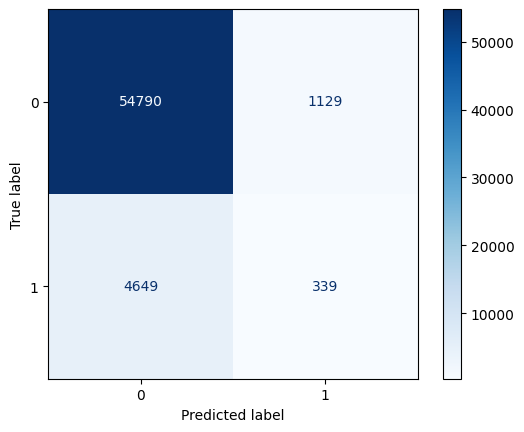

In [120]:
# Predict on the validation set
y_val_pred = model.predict(X_val_scaled).round().astype(int)

# Create the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [121]:
# Print classification report
print(classification_report(y_val, y_val_pred))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC-AUC Score: {roc_auc}')

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     55919
           1       0.23      0.07      0.11      4988

    accuracy                           0.91     60907
   macro avg       0.58      0.52      0.53     60907
weighted avg       0.87      0.91      0.88     60907

ROC-AUC Score: 0.5238865969540976


In [ ]:
# Predict on the test set
df_test['TARGET'] = model.predict(X_test_scaled).round().astype(int)

# Export the predictions to a CSV file
df_test.to_csv('df_test_predictions_deep_learning.csv', index=False)